In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score
)


In [8]:
df = pd.read_csv("../Data/final_engineered_features.csv")
df = df[df['Product Type'] == 'Food/Cosmetics'] #filtering for food products


# Drop non-relevant columns
df = df.drop(['classification_flag','Legal Name','City','Zip','FEI Number','Additional Details','FMD-145 Date','Inspection ID','Inspection End Date'], axis=1) 

# One-hot encoding categorical variables
categorical_cols = ['Classification', 'Project Area', 'Product Type', 'State', 'Country/Area', 'inspection_season'] 
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=int) 
df['Posted Citations'] = df['Posted Citations'].notnull().astype(int) #converting Posted Citations to binary



# row count
print(f"Row count: {df.shape[0]}", 'recall bool 0:', df['recalled_bool'].value_counts()[0], 'recall bool 1:', df['recalled_bool'].value_counts()[1])

# random rows
df.sample(5)

/var/folders/nt/9z_y1zvs4fv44k33p7cff_cc0000gp/T/ipykernel_79421/2292763708.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../Data/final_engineered_features.csv")


Row count: 173494 recall bool 0: 158176 recall bool 1: 15318


,Fiscal Year,Posted Citations,recalled_bool,inspection_year,inspection_month,inspection_dayofweek,inspection_quarter,week_of_year,days_since_last_inspection,Classification_Official Action Indicated (OAI),...,Country/Area_United Kingdom,Country/Area_United States,Country/Area_Uruguay,Country/Area_Vanuatu,Country/Area_Venezuela,Country/Area_Vietnam,Country/Area_Western Samoa,inspection_season_Spring,inspection_season_Summer,inspection_season_Winter
134350,2015,1,0,2014,10,3,4,44,1162.0,0,...,0,1,0,0,0,0,0,0,0,0
220558,2014,1,0,2013,10,4,4,43,437.0,1,...,0,1,0,0,0,0,0,0,0,0
94969,2021,1,0,2021,9,2,3,36,1322.0,0,...,0,1,0,0,0,0,0,0,0,0
141552,2020,1,0,2019,10,4,4,42,1088.0,0,...,0,1,0,0,0,0,0,0,0,0
140349,2009,1,0,2009,8,1,3,35,-1.0,1,...,0,0,0,0,0,0,0,0,1,0


In [9]:
X = df.drop(['recalled_bool'], axis=1)
y = df['recalled_bool']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

Code for comparing pre tuned naive models using cross validation

<Figure size 400x400 with 0 Axes>

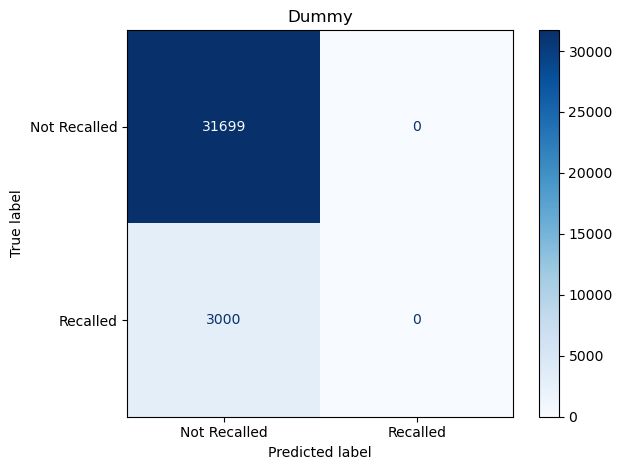

<Figure size 400x400 with 0 Axes>

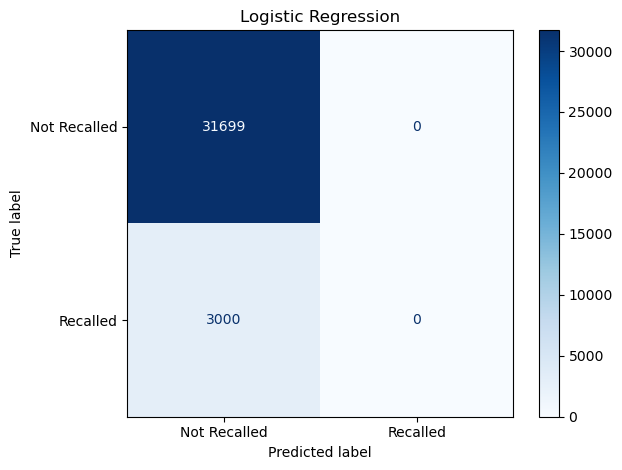

<Figure size 400x400 with 0 Axes>

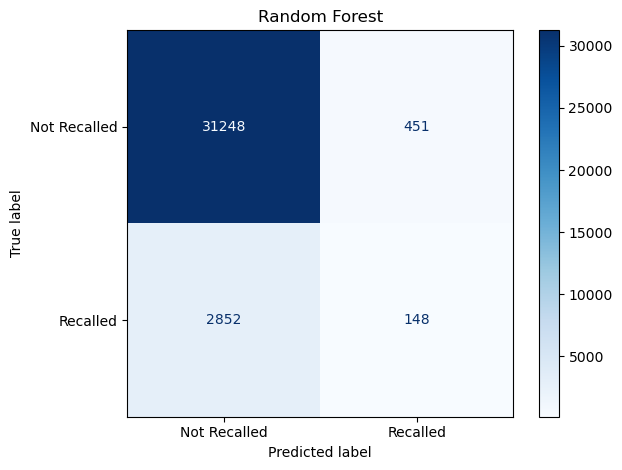

<Figure size 400x400 with 0 Axes>

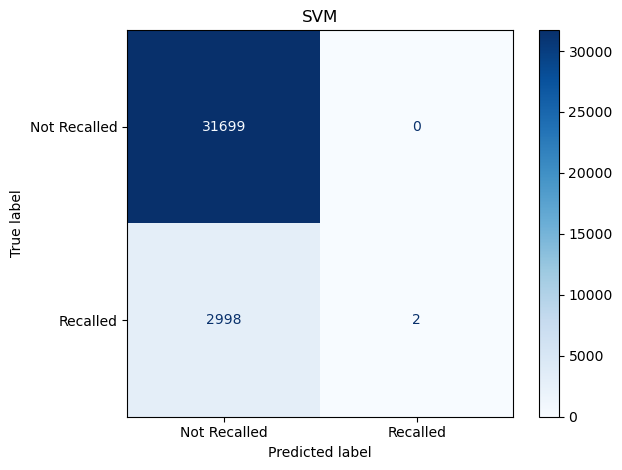


Cross-validation results:
                     F1 Score (No Recall)  F1 Score (Recall)  Accuracy  \
Dummy                            0.954818           0.000000  0.913542   
Logistic Regression              0.954818           0.000000  0.913542   
Random Forest                    0.949802           0.082245  0.904810   
SVM                              0.954847           0.001332  0.913600   

                     Precision (No Recall)  Precision (Recall)  
Dummy                             1.000000            0.000000  
Logistic Regression               1.000000            0.000000  
Random Forest                     0.985772            0.049333  
SVM                               1.000000            0.000667  


In [10]:
# Using pipelines for scaling and model fitting
models = {
    'Dummy': Pipeline([('scaler', StandardScaler()), ('classifier', DummyClassifier(strategy='most_frequent', random_state=42))]),

    'Logistic Regression': Pipeline([('scaler', StandardScaler()), ('classifier', LogisticRegression(solver='liblinear', random_state=42))]),

    'Random Forest': Pipeline([('scaler', StandardScaler()), ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))]),
    
    'SVM': Pipeline([('scaler', StandardScaler()), ('classifier', SVC(kernel='rbf', random_state=42))])
}


# results will hold the cross validation results
results1 = np.zeros((4, 5))

# Train and evaluate each model
for i, (name, model) in enumerate(models.items()):
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    results1[i, 0] = report['0']['f1-score']
    results1[i, 1] = report['1']['f1-score']
    results1[i, 2] = report['accuracy']
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    results1[i, 3] = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0
    results1[i, 4] = cm[1, 1] / (cm[1, 0] + cm[1, 1]) if (cm[1, 0] + cm[1, 1]) > 0 else 0
    # Plot confusion matrix
    plt.figure(figsize=(4,4))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Recalled', 'Recalled'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(name)
    plt.tight_layout()
    plt.show()

# Use results to create a DataFrame for better visualization
results1_df = pd.DataFrame(results1, columns=['F1 Score (No Recall)', 'F1 Score (Recall)', 'Accuracy', 'Precision (No Recall)', 'Precision (Recall)'],
                            index=models.keys())
print("\nCross-validation results:")
pd.set_option('display.max_columns', None)
print(results1_df)

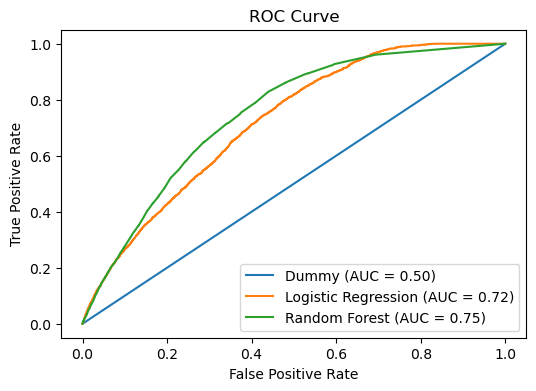

In [11]:
# For each model, plot ROC curve in the same figure and calculate AUC
plt.figure(figsize=(6, 4))

for i, (name, model) in enumerate(models.items()):
    if name != 'SVM':  # SVM does not support predict_proba 

        y_prob = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc = roc_auc_score(y_test, y_prob)

        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Code for final model (tuned) selection using cross validation
1. hyperparameter tuning for Random Forest and SVM done using GridSearchCV in their respective notebooks
2. class weight is balanced since the data is imbalanced, leaning toward not recalled

<Figure size 400x400 with 0 Axes>

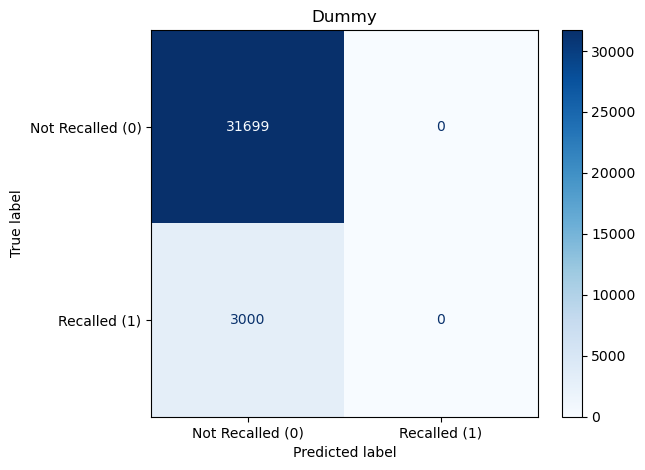

<Figure size 400x400 with 0 Axes>

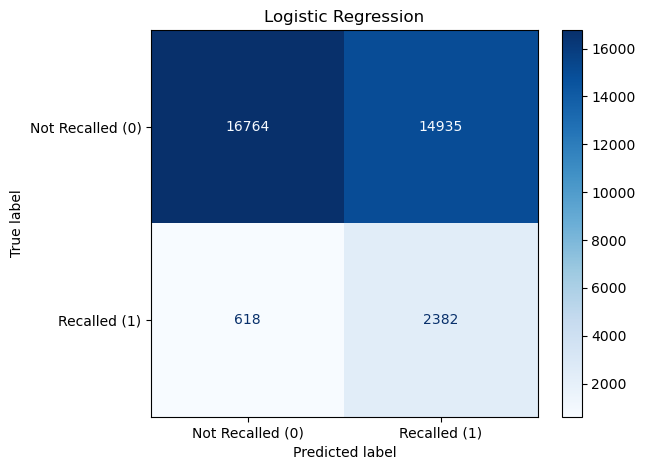

<Figure size 400x400 with 0 Axes>

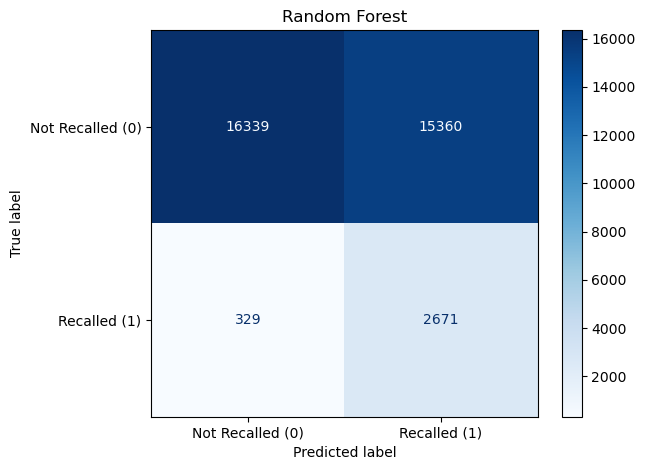

<Figure size 400x400 with 0 Axes>

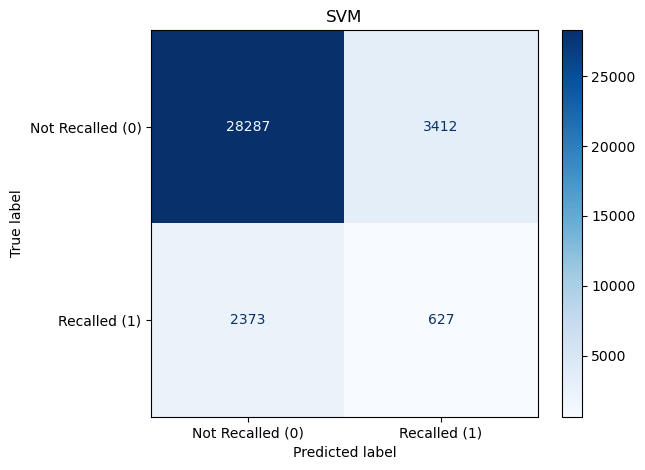


Cross-validation results:
                     F1 Score (No Recall)  F1 Score (Recall)  Accuracy  \
Dummy                            0.954818           0.000000  0.913542   
Logistic Regression              0.683116           0.234483  0.551774   
Random Forest                    0.675626           0.254006  0.547854   
SVM                              0.907231           0.178150  0.833280   

                     Precision (No Recall)  Precision (Recall)  
Dummy                             1.000000            0.000000  
Logistic Regression               0.528849            0.794000  
Random Forest                     0.515442            0.890333  
SVM                               0.892363            0.209000  


In [12]:
# Using pipelines for scaling and model fitting
models = {
    'Dummy': Pipeline([('scaler', StandardScaler()), ('classifier', DummyClassifier(strategy='most_frequent', random_state=42))]),

    'Logistic Regression': Pipeline([('scaler', StandardScaler()), ('classifier', LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42))]),

    'Random Forest': Pipeline([('scaler', StandardScaler()), ('classifier', RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=10,
                       min_samples_leaf=2, min_samples_split=5,
                       random_state=42))]),
    
    'SVM': Pipeline([('scaler', StandardScaler()), ('classifier', SVC(C=100, class_weight='balanced', gamma=1, kernel='rbf', random_state=42))])
}


# results will hold the cross validation results
results2 = np.zeros((4, 5))

# Train and evaluate each model
for i, (name, model) in enumerate(models.items()):
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    results2[i, 0] = report['0']['f1-score']
    results2[i, 1] = report['1']['f1-score']
    results2[i, 2] = report['accuracy']
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    results2[i, 3] = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0
    results2[i, 4] = cm[1, 1] / (cm[1, 0] + cm[1, 1]) if (cm[1, 0] + cm[1, 1]) > 0 else 0
    # Plot confusion matrix
    plt.figure(figsize=(4,4))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Recalled (0)', 'Recalled (1)'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(name)
    plt.tight_layout()
    plt.show()


# Use results to create a DataFrame for better visualization
results2_df = pd.DataFrame(results2, columns=['F1 Score (No Recall)', 'F1 Score (Recall)', 'Accuracy', 'Precision (No Recall)', 'Precision (Recall)'],
                            index=models.keys())
print("\nCross-validation results:")
pd.set_option('display.max_columns', None)
print(results2_df)

In [3]:
#weighted F1
n0 = 158176 
n1 = 15318
f10 = [0.954818, 0.683116, 0.675626, 0.907231]
f11 = [0, 0.234483, 0.254006, 0.178150]
wf1 = []
for i in range(len(f10)):
    wf1.append((n0*f10[i]+n1*f11[i])/(n0+n1))
print(wf1)

[0.8705159369661198, 0.6435056371401892, 0.6384006483451876, 0.842859536099231]


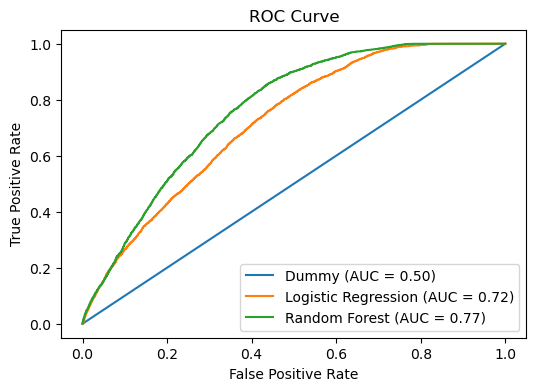

In [13]:
# For each model, plot ROC curve in the same figure and calculate AUC
plt.figure(figsize=(6, 4))

for i, (name, model) in enumerate(models.items()):
    if name != 'SVM':  # SVM does not support predict_proba 

        y_prob = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc = roc_auc_score(y_test, y_prob)

        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()